# Model Evaluation
In this work, we evaluate the performance of our model using Root Mean Square Error (RMSE). 

In [19]:
import numpy as np
from numpy import ndarray

## Data Preparation

In [20]:
# Load 5 folds of the dataset
# Each fold contains a training set and a test set
import pandas as pd
training_ratings: list[ndarray] = []
test_ratings: list[ndarray] = []
for i in range(0, 5):
    training_ratings.append(pd.read_csv(f'../data/ml-100k/u{i+1}.base', sep='\t', 
                                        usecols=[0, 1, 2],
                                        names=['user_id', 'item_id', 'rating']).to_numpy())
    test_ratings.append(pd.read_csv(f'../data/ml-100k/u{i+1}.test', sep='\t',
                                    usecols=[0, 1, 2],
                                    names=['user_id', 'item_id', 'rating']).to_numpy())
training_ratings[0][0:10, :] # user_id, item_id, rating
len(training_ratings)

5

In [21]:
data_info = pd.read_csv('../data/ml-100k/u.info', sep=' ', header=None)
n_users = data_info.iloc[0, 0]
n_items = data_info.iloc[1, 0]
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 943
Number of items: 1682


In [22]:
# For content-based filtering, we need the genres info of the movies
# Genres name
genres = pd.read_csv('../data/ml-100k/u.genre', sep='|', encoding='latin-1',
                           usecols=[0],names=['genre'])
genres.head(5)

,genre
0,unknown
1,Action
2,Adventure
3,Animation
4,Children's


In [23]:
# Genres info of the movies
movies_genres = pd.read_csv('../data/ml-100k/u.item', sep='|', encoding='latin-1',
                     index_col=0, header=None, 
                     names=genres['genre'].to_list(), 
                     usecols=list(range(5, 24)))
movies_genres.head(5) 

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
unknown,,,,,,,,,,,,,,,,,,
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [24]:
results = {} # Store the results of models

## Content-Based Filtering

### Data Preprocessing
Now each movie feature is represented as a vector, where each dimension corresponds to a genre. We transform the genres vector of each movie into a TF-IDF vector. 

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is commonly used in text mining and information retrieval to transform text data into numerical vectors that can be used for machine learning algorithms. Here we use TF-IDF to make the genre representation of movies more meaningful for similarity calculations.

- Term Frequency (TF): Measures how often a genre appears for a movie. For example, if a movie belongs to multiple genres, the frequency of each genre is considered.
- Inverse Document Frequency (IDF): Reduces the weight of genres that are common across many movies (e.g., "Drama") and increases the weight of rare genres (e.g., "Sci-Fi").

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_item_matrix = tfidf_transformer.fit_transform(movies_genres)
item_features = pd.DataFrame(tfidf_item_matrix.toarray(),
                           columns=tfidf_transformer.get_feature_names_out(),
                           index=movies_genres.index)
item_features.head(5) # item_id, genre1, genre2, ...

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
unknown,,,,,,,,,,,,,,,,,,
0,0.000000,0.00000,0.74066,0.573872,0.349419,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0,0.536767,0.65097,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536767,0.0,0.0
0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
0,0.710652,0.00000,0.00000,0.000000,0.539759,0.000000,0.0,0.451259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0,0.000000,0.00000,0.00000,0.000000,0.000000,0.735504,0.0,0.363186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571953,0.0,0.0


### Evaluate Content-Based Filtering

In [26]:
# Run content-based filtering on the dataset without trasforming the item features by TF-IDF
%reload_ext autoreload
%autoreload 2
from content_based_filtering import ContentBasedFiltering
total_rmse_train = 0
total_rmse_test = 0
alpha = 8
for i in range(0, 5):
    recommender = ContentBasedFiltering(n_users, n_items, movies_genres.to_numpy(), alpha) # Use the original item features
    recommender.fit(training_ratings[i])
    
    rmse_training = recommender.evaluateRMSE(training_ratings[i])
    rmse_test = recommender.evaluateRMSE(test_ratings[i])
    print(f"Fold {i+1}: RMSE on Training Dataset: {rmse_training}, RMSE on Testing Dataset: {rmse_test}")
    total_rmse_train += rmse_training
    total_rmse_test += rmse_test
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")

Fold 1: RMSE on Training Dataset: 0.9415185295085927, RMSE on Testing Dataset: 1.042592133125792
Fold 2: RMSE on Training Dataset: 0.9440715973899299, RMSE on Testing Dataset: 1.0276519208887476
Fold 3: RMSE on Training Dataset: 0.9477853516567318, RMSE on Testing Dataset: 1.013891809497328
Fold 4: RMSE on Training Dataset: 0.9468867022879588, RMSE on Testing Dataset: 1.0197205256600375
Fold 5: RMSE on Training Dataset: 0.947133412149921, RMSE on Testing Dataset: 1.0218354934076195
Average RMSE on Training Dataset: 0.9454791185986269, Average RMSE on Testing Dataset: 1.0251383765159048


In [27]:
# Run content-based filtering on the dataset with TF-IDF item features
total_rmse_train = 0
total_rmse_test = 0
alpha = 8
for i in range(0, 5):
    # Use the TF-IDF transformed item features
    recommender = ContentBasedFiltering(n_users, n_items, item_features.to_numpy(), alpha)
    recommender.fit(training_ratings[i])
    
    rmse_training = recommender.evaluateRMSE(training_ratings[i])
    rmse_test = recommender.evaluateRMSE(test_ratings[i])
    print(f"Fold {i+1}: RMSE on Training Dataset: {rmse_training}, RMSE on Testing Dataset: {rmse_test}")
    total_rmse_train += rmse_training
    total_rmse_test += rmse_test
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['content_based_filtering'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

Fold 1: RMSE on Training Dataset: 0.9585423785730269, RMSE on Testing Dataset: 1.0396635368274565
Fold 2: RMSE on Training Dataset: 0.9607561774484409, RMSE on Testing Dataset: 1.025850109591233
Fold 3: RMSE on Training Dataset: 0.9643473103440325, RMSE on Testing Dataset: 1.012403645344894
Fold 4: RMSE on Training Dataset: 0.963364408828825, RMSE on Testing Dataset: 1.0169479474934993
Fold 5: RMSE on Training Dataset: 0.9636570909707545, RMSE on Testing Dataset: 1.0201648476213967
Average RMSE on Training Dataset: 0.962133473233016, Average RMSE on Testing Dataset: 1.0230060173756956


The average RMSE for the content-based filtering model on the test set with the original movie's genre features is **1.0251**.

The average RMSE for the content-based filtering model on the test set with the TF-IDF transformed movie's genre features is **1.0230**.

## Neighborhood-Based Collaborative Filtering

### User-Based Collaborative Filtering
The avarage RMSE on test set is 1.0595, which is a bit better than the results of the content-based filtering. 

In [28]:
from neighbourhood_based_CF import NeighborhoodCF

total_rmse_train = 0
total_rmse_test = 0

for i in range(0, 5):
    recommender = NeighborhoodCF(n_users, n_items, k=30, uuCF=True)
    recommender.fit(training_ratings[i])
    
    rmse_training = recommender.evaluateRMSE(training_ratings[i])
    rmse_test = recommender.evaluateRMSE(test_ratings[i])
    print(f"Fold {i+1}: RMSE on Training Dataset: {rmse_training}, RMSE on Testing Dataset: {rmse_test}")
    total_rmse_train += rmse_training
    total_rmse_test += rmse_test
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['user_based_CF'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

Fold 1: RMSE on Training Dataset: 1.0330093580940434, RMSE on Testing Dataset: 1.0690665424742682
Fold 2: RMSE on Training Dataset: 1.0567169655907669, RMSE on Testing Dataset: 1.0704344072354874
Fold 3: RMSE on Training Dataset: 1.0555516469135295, RMSE on Testing Dataset: 1.055567648406658
Fold 4: RMSE on Training Dataset: 1.0556828803321838, RMSE on Testing Dataset: 1.0554910489039748
Fold 5: RMSE on Training Dataset: 1.0361981927209163, RMSE on Testing Dataset: 1.0470508556484694
Average RMSE on Training Dataset: 1.047431808730288, Average RMSE on Testing Dataset: 1.0595221005337716


### Item-based CF: 
- Compute the similarity between items (movies) based on user ratings.
- Use the similarity scores to recommend items to users based on their past ratings.

In [29]:
from neighbourhood_based_CF import NeighborhoodCF

total_rmse_train = 0
total_rmse_test = 0
# Item-based collaborative filtering
for i in range(0, 5):
    recommender = NeighborhoodCF(n_users, n_items, k=30, uuCF=False)
    recommender.fit(training_ratings[i])
    
    rmse_training = recommender.evaluateRMSE(training_ratings[i])
    rmse_test = recommender.evaluateRMSE(test_ratings[i])
    print(f"Fold {i+1}: RMSE on Training Dataset: {rmse_training}, RMSE on Testing Dataset: {rmse_test}")
    total_rmse_train += rmse_training
    total_rmse_test += rmse_test
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['item_based_CF'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

Fold 1: RMSE on Training Dataset: 1.014389622363792, RMSE on Testing Dataset: 1.0483106587889226
Fold 2: RMSE on Training Dataset: 1.021522394554863, RMSE on Testing Dataset: 1.0518583152549124
Fold 3: RMSE on Training Dataset: 1.0165509811303082, RMSE on Testing Dataset: 1.0400619217902314
Fold 4: RMSE on Training Dataset: 1.0151171558842027, RMSE on Testing Dataset: 1.0371367224622197
Fold 5: RMSE on Training Dataset: 1.0096257912395818, RMSE on Testing Dataset: 1.0388607220524215
Average RMSE on Training Dataset: 1.0154411890345496, Average RMSE on Testing Dataset: 1.0432456680697413


The RMSE for the item-based collaborative filtering model on the test set is **1.0432**, wchich is better than the user-based collaborative filtering model.

However, I noted that both user-based and item-based CF cost more time than content-based filtering for training and testing. This is because the CF models need to compute the similarity matrix, which makes computational cost increase **quadratically** with the number of users (in user-based CF) or items (in item-based CF) $(O({n\_users}^2) and O({n\_items}^2))$.

## Matrix Factorization

In [30]:
%reload_ext autoreload
%autoreload 2
from matrix_factorization_CF import MatrixFactorizationCF
total_rmse_train = 0
total_rmse_test = 0

k = 2
alpha = 0.5
learning_rate = 0.5
epochs = 30

print("-------------Training model with k=", k, ", alpha=", alpha, ", learning_rate=", learning_rate, "-------------------")
for i in range(0, 5):
    recommender = MatrixFactorizationCF(n_users, n_items, k=k, alpha=alpha, learning_rate=learning_rate)
    print("Traing on fold", i+1, "...")
    recommender.fit(training_ratings[i], epochs=epochs)
    rmse_training = recommender.evaluateRMSE(training_ratings[i])
    rmse_test = recommender.evaluateRMSE(test_ratings[i])   
    total_rmse_train += rmse_training
    total_rmse_test += rmse_test
    print(f"Fold {i+1}: RMSE on Training Dataset: {rmse_training}, RMSE on Testing Dataset: {rmse_test}")
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['matrix_factorization_CF'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

-------------Training model with k= 2 , alpha= 0.5 , learning_rate= 0.5 -------------------
Traing on fold 1 ...
RMSE after 0 iters:  1.253908257410766 Loss:  26.13485755725704
RMSE after 10 iters:  1.0249119562207611 Loss:  7.919537397114128
RMSE after 20 iters:  1.024908931487261 Loss:  6.9104307266272915
Fold 1: RMSE on Training Dataset: 1.0249089306494568, RMSE on Testing Dataset: 1.0629951282658179
Traing on fold 2 ...
RMSE after 0 iters:  1.272372127004006 Loss:  26.141773188923125
RMSE after 10 iters:  1.0285906646008047 Loss:  7.918101301467548
RMSE after 20 iters:  1.028566180617026 Loss:  6.910271221840806
Fold 2: RMSE on Training Dataset: 1.0285661121652634, RMSE on Testing Dataset: 1.0467467487586872
Traing on fold 3 ...
RMSE after 0 iters:  1.2739407942298364 Loss:  26.410257861182917
RMSE after 10 iters:  1.0319789570712503 Loss:  7.953596931762304
RMSE after 20 iters:  1.031968230151793 Loss:  6.932714310417057
Fold 3: RMSE on Training Dataset: 1.031968205751037, RMSE on

The average RMSE for the matrix factorization model on the test set is **1.0437**, which is quiet similar to the item-based collaborative filtering model. However, the matrix factorization model is faster than the item-based CF mode, especially when the MF is trained. When the MF is already trained, the prediction time can be computed fast by simply compute inner product on the user and item latent vectors.

## Neural Collaborative Filtering

### Generalized Matrix Factorization (GMF)

In [40]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

from NCF.GMF import GMF
from NCF.utils import RatingDataset, train, evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
n_factors = 32

total_rmse_train = 0
total_rmse_test = 0

for i in range(1, 6):
    training_filepath = f'../data/ml-100k/u{i}.base'
    testing_filepath = f'../data/ml-100k/u{i}.test'
    
    training_dataset = RatingDataset(training_filepath)
    testing_dataset = RatingDataset(testing_filepath)
    
    training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
    testing_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
    model = GMF(n_users, n_items, n_factors).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(f"-----\nTraining fold {i}...")
    # Train the model
    train(model, training_dataloader, criterion, optimizer, device)
    
    # Evaluate the model on training dataset
    loss, rmse = evaluate(model, training_dataloader, criterion, device)
    print(f"Fold {i} - Training: Loss: {loss}, RMSE: {rmse}")
    total_rmse_train += rmse
    
    # Evaluate the model on testing dataset
    loss, rmse = evaluate(model, testing_dataloader, criterion, device)
    print(f"Fold {i} - Testing: Loss: {loss}, RMSE: {rmse}")
    total_rmse_test += rmse
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['GMF'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

-----
Training fold 1...
Loss and RMSE after 0 epochs:  (tensor(0.8795), 0.9378144359028406)
Loss and RMSE after 1 epochs:  (tensor(0.6892), 0.8301772817758107)
Fold 1 - Training: Loss: 0.6891942620277405, RMSE: 0.830177282141978
Fold 1 - Testing: Loss: 0.9084612131118774, RMSE: 0.9531318484075934
-----
Training fold 2...
Loss and RMSE after 0 epochs:  (tensor(0.8893), 0.9430009605829094)
Loss and RMSE after 1 epochs:  (tensor(0.7031), 0.8385320235951708)
Fold 2 - Training: Loss: 0.7031359672546387, RMSE: 0.8385320235098722
Fold 2 - Testing: Loss: 0.8827630877494812, RMSE: 0.9395549733364092
-----
Training fold 3...
Loss and RMSE after 0 epochs:  (tensor(0.8986), 0.9479556089464684)
Loss and RMSE after 1 epochs:  (tensor(0.7012), 0.837366953056901)
Fold 3 - Training: Loss: 0.7011839151382446, RMSE: 0.8373669528362399
Fold 3 - Testing: Loss: 0.8649613261222839, RMSE: 0.9300330440485607
-----
Training fold 4...
Loss and RMSE after 0 epochs:  (tensor(0.8832), 0.939795983011516)
Loss and R

The average RMSE on the test dataset of using GMF model (with n_factors = 32)  is **0.9373**, which is much better than all other traditional models.

## Multilayer Perceptron (MLP)

In [32]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

from NCF.MLP import MLP
from NCF.utils import RatingDataset, train, evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
hidden_layers_size = [128, 64, 32]
total_rmse_train = 0
total_rmse_test = 0

for i in range(1, 6):
    training_filepath = f'../data/ml-100k/u{i}.base'
    testing_filepath = f'../data/ml-100k/u{i}.test'
    
    training_dataset = RatingDataset(training_filepath)
    testing_dataset = RatingDataset(testing_filepath)
    
    training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
    testing_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
    model = MLP(n_users, n_items, hidden_layers_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(f"-----\nTraining fold {i}...")
    # Train the model
    train(model, training_dataloader, criterion, optimizer, device)
    
    # Evaluate the model on training dataset
    loss, rmse = evaluate(model, training_dataloader, criterion, device)
    print(f"Fold {i} - Training: Loss: {loss}, RMSE: {rmse}")
    total_rmse_train += rmse

    # Evaluate the model on testing dataset
    loss, rmse = evaluate(model, testing_dataloader, criterion, device)
    print(f"Fold {i} - Testing: Loss: {loss}, RMSE: {rmse}")
    total_rmse_test += rmse
    
print(f"Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['MLP'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

-----
Training fold 1...
Loss and RMSE after 0 epochs:  (tensor(0.8349), 0.9137225426254955)
Loss and RMSE after 1 epochs:  (tensor(0.7962), 0.8923035612826903)
Fold 1 - Training: Loss: 0.7962056398391724, RMSE: 0.8923035611357333
Fold 1 - Testing: Loss: 0.9024393558502197, RMSE: 0.9499680642858646
-----
Training fold 2...
Loss and RMSE after 0 epochs:  (tensor(0.8293), 0.910668768560718)
Loss and RMSE after 1 epochs:  (tensor(0.7805), 0.883444003582857)
Fold 2 - Training: Loss: 0.7804719805717468, RMSE: 0.8834440031105775
Fold 2 - Testing: Loss: 0.8800315260887146, RMSE: 0.9380999031750814
-----
Training fold 3...
Loss and RMSE after 0 epochs:  (tensor(0.8310), 0.9116133030612158)
Loss and RMSE after 1 epochs:  (tensor(0.7886), 0.888058137537843)
Fold 3 - Training: Loss: 0.7886472940444946, RMSE: 0.8880581371149999
Fold 3 - Testing: Loss: 0.8756042122840881, RMSE: 0.9357372723925864
-----
Training fold 4...
Loss and RMSE after 0 epochs:  (tensor(0.8358), 0.9142069635591491)
Loss and R

The average RMSE of the MLP model with hidden layer size = [128, 64, 32] is **0.9379**. The result is similar to the GMF model, but the MLP model clearly costs more time for training than GMF model due to the larger number of layers and neurons.

### Neural Collaborative Filtering (NCF)

In [33]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

from NCF.NCF import NeuralCF
from NCF.utils import RatingDataset, train, evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
n_factors_GMF = 32
hidden_layers_MLP = [128, 64, 32]

total_rmse_train = 0
total_rmse_test = 0

for i in range(1, 6):
    training_filepath = f'../data/ml-100k/u{i}.base'
    testing_filepath = f'../data/ml-100k/u{i}.test'
    
    training_dataset = RatingDataset(training_filepath)
    testing_dataset = RatingDataset(testing_filepath)
    
    training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
    testing_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
    model = NeuralCF(n_users, n_items, n_factors_GMF, hidden_layers_MLP).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"-----\nTraining fold {i}...")
    # Train the model
    train(model, training_dataloader, criterion, optimizer, device)
    
    # Evaluate the model on training dataset
    loss, rmse = evaluate(model, training_dataloader, criterion, device)
    total_rmse_train += rmse
    print(f"Fold {i} - Training: Loss: {loss}, RMSE: {rmse}")
    
    # Evaluate the model on the testing dataset
    loss, rmse = evaluate(model, testing_dataloader, criterion, device)
    print(f"Fold {i} - Testing: Loss: {loss}, RMSE: {rmse}")
    total_rmse_test += rmse
print(f"---> Average RMSE on Training Dataset: {total_rmse_train/5}, Average RMSE on Testing Dataset: {total_rmse_test/5}")
results['NCF'] = {
    'train_rmse': total_rmse_train / 5,
    'test_rmse': total_rmse_test / 5
}

-----
Training fold 1...
Loss and RMSE after 0 epochs:  (tensor(0.8215), 0.9063681236827481)
Loss and RMSE after 1 epochs:  (tensor(0.5600), 0.7483467962814954)
Fold 1 - Training: Loss: 0.5600226521492004, RMSE: 0.7483467960146731
Fold 1 - Testing: Loss: 0.8625775575637817, RMSE: 0.9287506962076609
-----
Training fold 2...
Loss and RMSE after 0 epochs:  (tensor(0.8055), 0.8974701234366073)
Loss and RMSE after 1 epochs:  (tensor(0.5724), 0.7565659510877667)
Fold 2 - Training: Loss: 0.5723927021026611, RMSE: 0.7565659520961909
Fold 2 - Testing: Loss: 0.8486039042472839, RMSE: 0.9211970106229591
-----
Training fold 3...
Loss and RMSE after 0 epochs:  (tensor(0.8073), 0.898512300757662)
Loss and RMSE after 1 epochs:  (tensor(0.5686), 0.7540242241655388)
Fold 3 - Training: Loss: 0.5685527920722961, RMSE: 0.7540242245607824
Fold 3 - Testing: Loss: 0.8467305898666382, RMSE: 0.9201796572132795
-----
Training fold 4...
Loss and RMSE after 0 epochs:  (tensor(0.8062), 0.8978937453127203)
Loss and

The average RMSE of the NCF model with n_factors of GMF = 32 and hidden layer size of MLP = [128, 64, 32] is **0.9203**. This result is the best among all models we have trained. This results can be explained by the fact that NCF combines both GMF and MLP moedels, which allows the model to learn both linear and non-linear interactions between users and items. The GMF part captures the linear relationships, while the MLP part captures the non-linear relationships. This combination leads to better performance compared to using either model alone.

## Visualization

In [41]:
### Sort the models by RMSE on the test set
sorted_models = sorted(results.items(), key=lambda x: x[1]['test_rmse'])[::-1]
models = [m[0] for m in sorted_models]
train_rmse = [m[1]['train_rmse'] for m in sorted_models]
test_rmse = [m[1]['test_rmse'] for m in sorted_models]

In [42]:
# Print the results
sorted_df = pd.DataFrame(
    {k: {'train_rmse': float(v['train_rmse']), 'test_rmse': float(v['test_rmse'])} for k, v in sorted_models}
).T.round(4)

print("Model Comparison:\n")
print(sorted_df.to_markdown(tablefmt="grid"))

Model Comparison:

+-------------------------+--------------+-------------+
|                         |   train_rmse |   test_rmse |
+=========================+==============+=============+
| user_based_CF           |       1.0474 |      1.0595 |
+-------------------------+--------------+-------------+
| matrix_factorization_CF |       1.0296 |      1.0437 |
+-------------------------+--------------+-------------+
| item_based_CF           |       1.0154 |      1.0432 |
+-------------------------+--------------+-------------+
| content_based_filtering |       0.9621 |      1.023  |
+-------------------------+--------------+-------------+
| MLP                     |       0.8901 |      0.9379 |
+-------------------------+--------------+-------------+
| GMF                     |       0.8397 |      0.9374 |
+-------------------------+--------------+-------------+
| NCF                     |       0.7511 |      0.9203 |
+-------------------------+--------------+-------------+


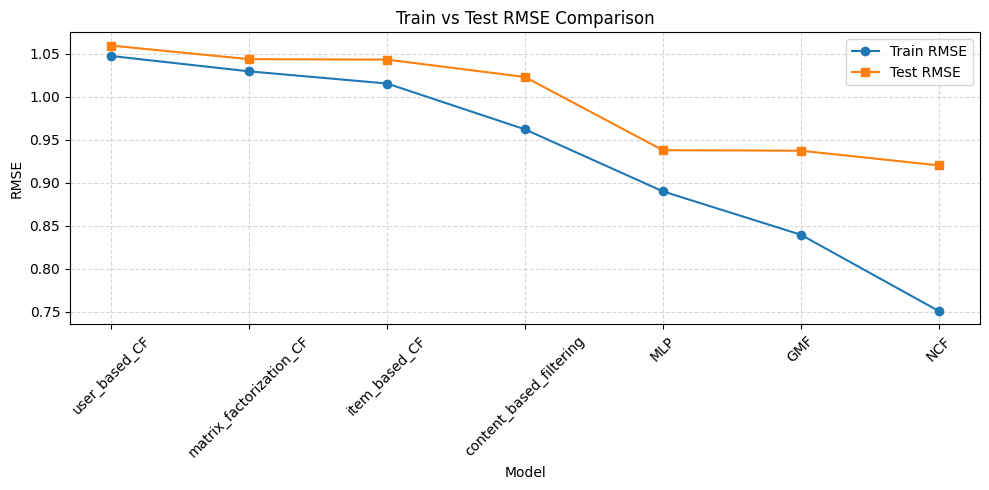

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(models, train_rmse, marker='o', label='Train RMSE')
plt.plot(models, test_rmse, marker='s', label='Test RMSE')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title('Train vs Test RMSE Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()